In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import FFNet
from cosmosis.learning import Learn, Selector
from cosmosis.dataset import SKDS

from dataset import QM7, QM7b, QM7X, QM9, ANI1x

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
from torch.optim.lr_scheduler import ReduceLROnPlateau

RDKit WARNING: [10:28:06] Enabling RDKit 2019.09.3 jupyter extensions


CDataset created...
SKDS make_regression created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:03.545866
epoch: 0, lr: 0.01
train loss: 21509.72847945602, val loss: 15016.733984375
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:08.591911
epoch: 10, lr: 0.005
train loss: 502.7941318088108, val loss: 514.3794189453125
sklearn train metric: 0, sklearn validation metric: 0
test loss: 339.33800354003904
learning time: 0:00:13.275316
sklearn test metric: 
0 



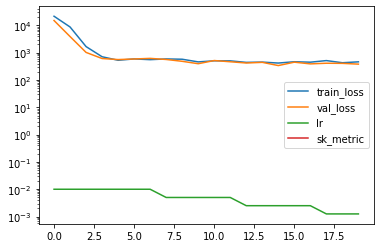

In [2]:
model_params = {'D_in': 128, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'make': 'make_regression',
                              'transform': [],
                              'target_transform': [],
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 128}}}

metrics_params = {'report_interval': 10}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([SKDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=20)

CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:00.830451
epoch: 0, lr: 0.01
train loss: 1531.0971872430098, val loss: 1500.9606628417969
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:07.903716
epoch: 10, lr: 0.01
train loss: 34.733787034687246, val loss: 36.75001525878906
sklearn train metric: 0, sklearn validation metric: 0
test loss: 32.817152976989746
learning time: 0:00:14.466181
sklearn test metric: 
0 



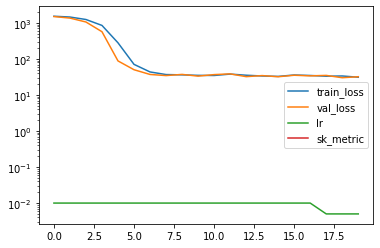

In [3]:
model_params = {'D_in': 23*23+23*32, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atoms',7,32,None,True)]}

ds_params = {'train_params': {'features': ['coulomb'],
                              'targets': ['ae'],
                              'embeds': ['atoms'],
                              'in_file': './data/qm7/qm7.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=20)

CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:00.495583
epoch: 0, lr: 0.01
train loss: 1562.0803158408717, val loss: 1545.0146484375
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:05.305142
epoch: 10, lr: 0.01
train loss: 56.97621777183131, val loss: 59.15102767944336
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:10.097973
epoch: 20, lr: 0.01
train loss: 47.469173632170026, val loss: 56.348557472229004
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:14.825286
epoch: 30, lr: 0.005
train loss: 40.21843137239155, val loss: 51.1881046295166
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:19.686026
epoch: 40, lr: 0.0025
train loss: 39.08865757992393, val loss: 50.06923484802246
sklearn train metric: 0, sklearn validation metric: 0
test loss: 54.02713966369629
learning time: 0:00:24.213089
sklearn test metric: 
0 



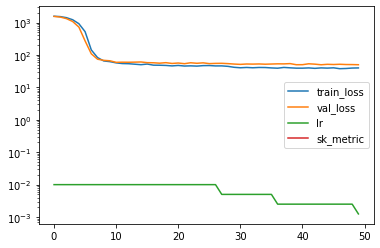

In [4]:
model_params = {'D_in': 23*23, 
                'H': 2048, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['coulomb'],
                              'targets': ['E'],
                              'in_file': './data/qm7b/qm7b.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=50)

In [ ]:
#find the longest molecule

ds_params = {'train_params': {'features': ['atNUM'],
                              'pad': None,
                              'targets': [],
                              'embeds': [],
                              'selector': ['opt']}}

qm7x = QM7X(**ds_params['train_params'])
l = 0
for i in qm7x.ds_idx:
    s = qm7x[i][0].shape[0]
    if s > l:
        l = s
print('longest molecule length: ', l)

qm7x[1]

In [5]:
model_params = {'D_in': 23*23+23*64, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atNUM',9,64,None,True)]}

ds_params = {'train_params': {'features': ['distance'],
                              'pad': 23,
                              'do_not_pad':['eAT'],
                              'targets': ['eAT'],
                              'embeds': ['atNUM'],
                              'selector': ['opt'],
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=50)

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>


RuntimeError: Can't determine # of objects (unknown symbol table entry cache type)

creating QM9 dataset...
QM9 molecules scanned:  1
QM9 molecules created:  1
total uncharacterized molecules removed:  273
total QM9 molecules created:  9727
CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:01.014877
epoch: 0, lr: 0.01
train loss: 337.34293658916766, val loss: 289.5316101074219
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:09.843342
epoch: 10, lr: 0.01
train loss: 8.208510398864746, val loss: 7.8815226554870605
sklearn train metric: 0, sklearn validation metric: 0
test loss: 7.883076190948486
learning time: 0:00:18.010552
sklearn test metric: 
0 



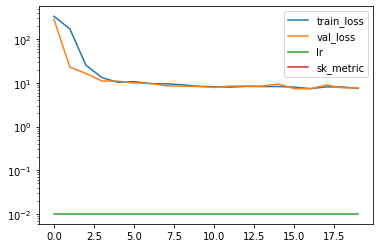

In [6]:
model_params = {'D_in': 29*29+12+29,
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'n': 10000, 
                              'features': ['n_atoms','A','B','C','mu','alpha','homo','lumo', 
                                           'gap','r2','zpve','Cv','mulliken','coulomb'],
                              'embeds': [], 
                              'targets': ['U0'],
                              'pad': 29,
                              'do_not_pad': ['n_atoms','A','B','C','mu','alpha','homo','lumo',
                                             'gap','r2','zpve','Cv','U0'],
                              'filter_on': None,
                              'use_pickle': False,
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=20)

creating QM9 dataset...
QM9 molecules scanned:  1
QM9 molecules created:  0
QM9 molecules scanned:  10001
QM9 molecules created:  1853
QM9 molecules scanned:  20001
QM9 molecules created:  4109
QM9 molecules scanned:  30001
QM9 molecules created:  5164
QM9 molecules scanned:  40001
QM9 molecules created:  8487
total uncharacterized molecules removed:  66
total QM9 molecules created:  9934
CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:01.084527
epoch: 0, lr: 0.01
train loss: 355.667081479673, val loss: 304.2617248535156
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:10.731004
epoch: 10, lr: 0.01
train loss: 7.858704107779044, val loss: 7.599758720397949
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:20.053489
epoch: 20, lr: 0.005
train loss: 6.859133985307482, val loss: 7.316341495513916
sklearn train metric: 0, sklearn validation metric: 0
test loss: 6.944905185699463
learning time: 0:00:28.608906
sk

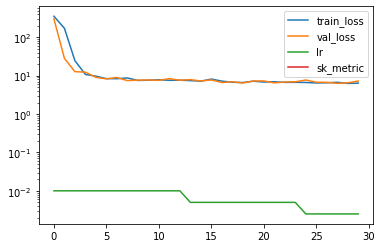

In [8]:
model_params = {'D_in': 29*29+29+12, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': []}

ds_params = {'train_params': {'n': 10000,
                              'features': ['n_atoms','A','B','C','mu','alpha','homo','lumo', 
                                           'gap','r2','zpve','Cv','mulliken','coulomb'],
                              'embeds': [],
                              'targets': ['U0'],
                              'pad': 29,
                              'do_not_pad': ['n_atoms','A','B','C','mu','alpha','homo','lumo',
                                             'gap','r2','zpve','Cv','U0'],
                              'filter_on': ('n_atoms','>','18'),
                              'use_pickle': False,
                              'flatten': True}}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}
opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=30)

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:02.309098
epoch: 0, lr: 0.01
train loss: 564.4470717486213, val loss: 530.0391438802084
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:12.321226
epoch: 6, lr: 0.01
train loss: 43.77135602165671, val loss: 37.441183725992836
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:19.008889
epoch: 10, lr: 0.01
train loss: 40.39974930707146, val loss: 35.46899286905924
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:30.703862
epoch: 17, lr: 0.005
train loss: 29.53042490342084, val loss: 29.640653610229492
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:35.752526
epoch: 20, lr: 0.005
train loss: 30.14124084921444, val loss: 36.15689214070638
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:45.87388

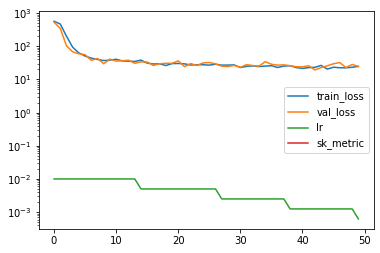

In [9]:
model_params = {'D_in': 63*63+63*32, 
                'H': 8192, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atomic_numbers',9,32,None,True)]}

ds_params = {'train_params': {'features': ['distance'],
                              'targets': ['wb97x_dz.energy'],
                              'embeds': ['atomic_numbers'],
                              'pad': 63, #length of the longest molecule in the dataset
                              'flatten': True,
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'random',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

metrics_params = {'report_interval': 20}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=128, epochs=50)